In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
import json

Valassis Digital has run a digital advertising campaign for one of our clients. We ran two creatives during the campaign, one old and one new. Users in a "test" group received the new ad during the campaign. The goal of my analysis was to answer 2 questions. Did the new creative increase conversions? Would retargeting have improved performance for this campaign?


## Data Prep

In [2]:
users=pd.read_csv('../user_attributes.csv')

In [3]:
users.head()

,user_id,attributes
0,00003e3b9e5336685200ae85d21b4f5e,"{""age"": 33, ""gender"": ""F"", ""location"": ""FL"", ""..."
1,000053b1e684c9e7ea73727b2238ce18,"{""age"": 26, ""gender"": ""M"", ""location"": ""AL"", ""..."
2,00029153d12ae1c9abe59c17ff2e0895,"{""age"": 29, ""gender"": ""F"", ""location"": ""AR"", ""..."
3,0002ac0d783338cfeab0b2bdbd872cda,"{""age"": 29, ""gender"": ""M"", ""location"": ""SC"", ""..."
4,0004d0b59e19461ff126e3a08a814c33,"{""age"": 27, ""gender"": ""F"", ""location"": ""AR"", ""..."


In [4]:
bids=pd.read_csv('../bid_requests.csv')
bids.head()

,timestamp,user_id,bid,win,conversion
0,2017-01-01 00:00:01,be7485be5b6eb3690efcbc9e95e8f15a,0,0,0
1,2017-01-01 00:00:02,26c5dca2512a4c7fe8810bd04191b1b3,0,0,0
2,2017-01-01 00:00:05,2121376a323507c01c5e92c39ae8ccd4,0,0,0
3,2017-01-01 00:00:12,fa6a0925d911185338b0acc93c66dc92,0,0,0
4,2017-01-01 00:00:13,4299f209da83da82b711f1d631cc607b,1,0,0


In [5]:
columns=list(json.loads(users['attributes'][0]).keys())

In [6]:
users2=pd.DataFrame(np.asarray(list(users['attributes'].apply(lambda x: sorted(json.loads(x).items()))))[:,:,1],columns=columns)
users2['user_id']=users['user_id']
users2.head()

,age,gender,location,test,user_id
0,33,F,FL,1,00003e3b9e5336685200ae85d21b4f5e
1,26,M,AL,1,000053b1e684c9e7ea73727b2238ce18
2,29,F,AR,1,00029153d12ae1c9abe59c17ff2e0895
3,29,M,SC,0,0002ac0d783338cfeab0b2bdbd872cda
4,27,F,AR,1,0004d0b59e19461ff126e3a08a814c33


In [7]:
users2['test']=users2['test'].apply(lambda x: int(x))
users2['age']=users2['age'].apply(lambda x: float(x))

In [8]:
users2=users2.drop_duplicates().reset_index(drop=True)
bids=bids.drop_duplicates().reset_index(drop=True)
final=users2.merge(bids,on='user_id',how='left')

In [9]:
bids=bids.dropna().reset_index(drop=True)
users2=users2.dropna().reset_index(drop=True)
final=final.dropna().reset_index(drop=True)
final.head()

,age,gender,location,test,user_id,timestamp,bid,win,conversion
0,33.0,F,FL,1,00003e3b9e5336685200ae85d21b4f5e,2017-01-01 13:43:34,1.0,0.0,0.0
1,33.0,F,FL,1,00003e3b9e5336685200ae85d21b4f5e,2017-01-04 03:59:18,0.0,0.0,0.0
2,33.0,F,FL,1,00003e3b9e5336685200ae85d21b4f5e,2017-01-04 17:41:50,1.0,1.0,0.0
3,33.0,F,FL,1,00003e3b9e5336685200ae85d21b4f5e,2017-01-07 04:02:42,1.0,1.0,0.0
4,33.0,F,FL,1,00003e3b9e5336685200ae85d21b4f5e,2017-01-08 09:05:01,1.0,0.0,0.0


In [10]:
test=pd.DataFrame(users2[users2['test']==1])
control=pd.DataFrame(users2[users2['test']==0])

In [11]:
test2=pd.DataFrame(final[final['test']==1])
control2=pd.DataFrame(final[final['test']==0])

## Find obvious bias

In [12]:
print('Sizes:Test {},Control {}'.format(len(test), len(control)))

Sizes:Test 56084,Control 43916


### Gender distributions in the test and control groups were about the same

In [13]:
print('Gender in the test group')
test['gender'].value_counts()/len(test)*100

Gender in the test group


F    50.117681
M    49.882319
Name: gender, dtype: float64

In [14]:
print('Gender  in the control group')
control['gender'].value_counts()/len(control)*100

Gender  in the control group


M    50.325622
F    49.674378
Name: gender, dtype: float64

### Location distributions in the test and control groups were different, which could affect results.

Text(0.5, 1.0, 'Location in the test group')

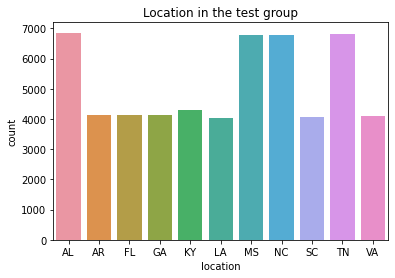

In [15]:
sns.countplot(test['location'].sort_values())
plt.title('Location in the test group')

Text(0.5, 1.0, 'Location in the control group')

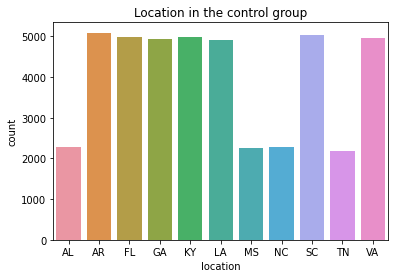

In [16]:
sns.countplot(control['location'].sort_values())
plt.title('Location in the control group')

### Age distributions in the test and control groups were about the same.

In [17]:
print('Age in the test and control groups')
print('Median: Test {},Control {}'.format(np.median(test['age']), np.median(control['age'])))
print('Mean: Test {},Control {}'.format(np.mean(test['age']), np.mean(control['age'])))
print('Standard Deviation: Test {},Control {}'.format(np.std(test['age']),np.std(control['age'])))

Age in the test and control groups
Median: Test 25.0,Control 25.0
Mean: Test 25.493830682547607,Control 25.488364149740413
Standard Deviation: Test 4.6043110471866955,Control 4.599852715678207


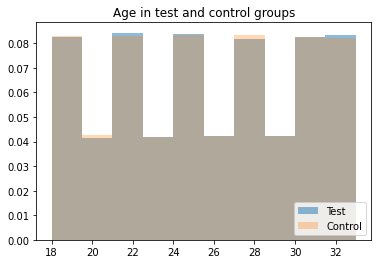

In [18]:
plt.hist(test['age'], density=True,label = "Test", alpha = .5)
plt.hist(control['age'],density=True,label = 'Control', alpha = .3)
plt.title('Age in test and control groups')
plt.legend(loc ='lower right')

## Experiment results

- The percentage of bids tells us the percentage of user requests we bid on
- The percentage of wins tells us how many ads we were able to serve, out of all of the bids we made.
- The conversion rate tells us how many accepted offers there were, out of all of the times the ad was served.

In [19]:
print("Percentage of Bids")
print('Test {},Control {}'.format(np.mean(test2['bid'])*100,np.mean(control2['bid'])*100))

Percentage of Bids
Test 49.97025685646047,Control 49.977680870789406


In [20]:
#only look at wins for bids
bidtest=test2[test2['bid']==1]
bidcontrol=control2[control2['bid']==1]

print("Percentage of Bids Won")
print('Test {},Control {}'.format(np.mean(bidtest['win'])*100,np.mean(bidcontrol['win'])*100))

Percentage of Bids Won
Test 50.101867974367174,Control 50.05076529638536


### Conversion rates were different in different states. 

In [21]:
#only look at conversions for wins in each group
wintest=test2[test2['win']==1]
wincontrol=control2[control2['win']==1]

Text(0.5, 1.0, 'Conversion rates by location in the test group')

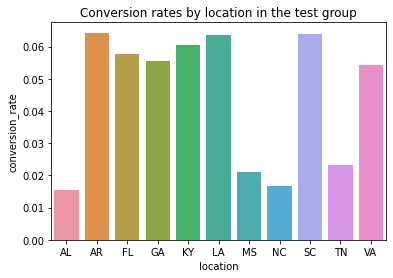

In [22]:
locs=pd.DataFrame(wintest.groupby(['location'])[['win','conversion']].sum()).reset_index()
locs['conversion_rate']=locs['conversion']/locs['win']
locs=locs.sort_values(['location'])
locs2=pd.DataFrame(wincontrol.groupby(['location'])[['win','conversion']].sum()).reset_index()
locs2['conversion_rate']=locs2['conversion']/locs2['win']
locs2=locs2.sort_values(['location'])

sns.barplot(locs['location'],locs['conversion_rate'])
plt.title('Conversion rates by location in the test group')

Text(0.5, 1.0, 'Conversion rates by location in the control group')

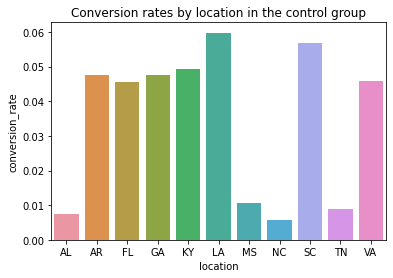

In [23]:
sns.barplot(locs2['location'],locs2['conversion_rate'])
plt.title('Conversion rates by location in the control group')

### The control group contained states with higher conversion rates. It's overall conversion rate may have been boosted because of this.

In [24]:
print("Overall Conversion rate")
print('Test {},Control {}'.format(np.mean(wintest['conversion'])*100,np.mean(wincontrol['conversion'])*100))

Overall Conversion rate
Test 4.009693244281578,Control 4.153193825880056


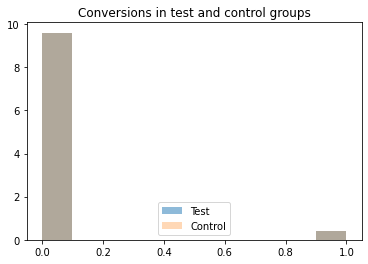

In [25]:
plt.hist(wintest['conversion'], density=True,alpha=0.5,label = "Test")
plt.hist(wincontrol['conversion'],density=True,alpha=0.3,label = 'Control')
plt.title('Conversions in test and control groups')
plt.legend(loc ='lower center')


### Was the difference in conversion rates just random? Since the distribution of sample means was skewed, I used the Mann Whitney U test to answer this question.

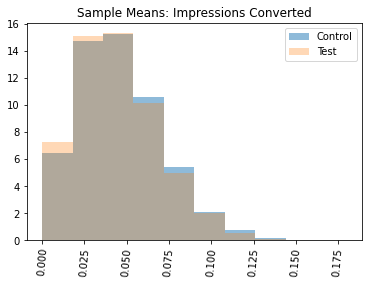

MannwhitneyuResult(statistic=2769213741.5, pvalue=0.08145325354797739)

In [26]:
#plot distribution of sample means and do p test
tests=[]
controls=[]


for i in range(10000):
    tes = np.random.choice(wintest['conversion'],50, replace=True).mean()
    con = np.random.choice(wincontrol['conversion'], 50, replace=True).mean()
    
    controls.append(con)
    tests.append(tes)

plt.hist(controls, alpha=0.5, density=True,label='Control') 
plt.hist(tests, alpha=0.3, density=True,label='Test') 
plt.xticks(rotation=85)
plt.legend(loc='upper right')
plt.title('Sample Means: Impressions Converted')
plt.show()

mannwhitneyu(wintest['conversion'], wincontrol['conversion'])

###  The P value for the Mann Whitney U test was above 0.05. This means I cannot conclude that the difference in conversion rates was anything but random. 

### Q-Q Plots

In [27]:
rand1=np.random.normal(1, .5, 100)
rand1.sort()
#tests and controls
wtest=np.random.choice(tests,100)
wcontrol=np.random.choice(controls,100)
wtest.sort()
wcontrol.sort()

### If the distribution of sample means was normal then these plots would form a diagonal line

Text(0.5, 1.0, 'Test sample means vs normal distribution')

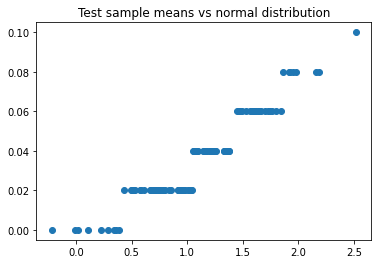

In [28]:
plt.plot(rand1,wtest,'o')
plt.title('Test sample means vs normal distribution')

Text(0.5, 1.0, 'Control sample means vs normal distribution')

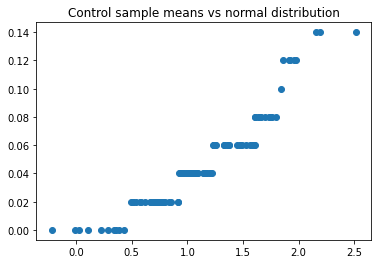

In [29]:
plt.plot(rand1,wcontrol,'o')
plt.title('Control sample means vs normal distribution')

## Retargeting

In [30]:
bidsgrp=pd.DataFrame(bids.groupby(['user_id'])[['bid','win','conversion']].sum())

In [31]:
rewin=pd.DataFrame(bidsgrp[bidsgrp['win']>1])
rewin['reconvert']=np.where(rewin['conversion']>1,1,0)

In [32]:
print("Percentage of users served more than once that converted more than once")
print(np.mean(rewin['reconvert'])*100)

Percentage of users served more than once that converted more than once
1.2141714525476621


### It doesn't make sense to target previously converted users. I'll see if it makes sense to target users who have been served the add previously.

In [33]:
wins=bids.sort_values(['user_id','timestamp']).reset_index(drop=True)

In [34]:
save='goo'
times=[]
for i,j in zip(wins['user_id'],wins['win']):
    if save!=i:
        count=0
    if j==1:
        count+=1
    times.append(count)
    save=i
wins['times_served']=times

In [35]:
wins.head()

,timestamp,user_id,bid,win,conversion,times_served
0,2017-01-01 13:43:34,00003e3b9e5336685200ae85d21b4f5e,1,0,0,0
1,2017-01-04 03:59:18,00003e3b9e5336685200ae85d21b4f5e,0,0,0,0
2,2017-01-04 17:41:50,00003e3b9e5336685200ae85d21b4f5e,1,1,0,1
3,2017-01-07 04:02:42,00003e3b9e5336685200ae85d21b4f5e,1,1,0,2
4,2017-01-08 09:05:01,00003e3b9e5336685200ae85d21b4f5e,1,0,0,2


### Let's see if the conversion rate increases for users who have been served the ad before.

In [36]:
timesies=pd.DataFrame(wins.groupby(['times_served']).agg({'bid':['count'],'win':['sum'],'conversion':['sum']}))
timesies.columns=['bid_requests','wins','conversions']
timesies=timesies.reset_index()
timesies['conversion_rate']=(timesies['conversions']/timesies['wins'])*100
totalbids=np.sum(timesies['bid_requests'])
timesies['percent_bid_requests']=(timesies['bid_requests']/totalbids)*100
timesies=timesies.fillna(0)
timesiesbid=pd.DataFrame(timesies[timesies['percent_bid_requests']>=1])

[Text(0, 0.5, ''), Text(0.5, 0, 'Number of times each user was served')]

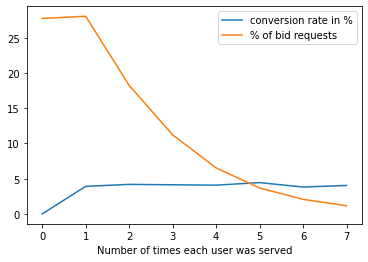

In [37]:
fig=sns.lineplot(x='times_served',y='conversion_rate',data=timesiesbid,label='conversion rate in %')
fig=sns.lineplot(x='times_served',y='percent_bid_requests',data=timesiesbid,label='% of bid requests')
plt.legend(loc ='upper right')
fig.set(xlabel='Number of times each user was served',ylabel='')
#plt.title("Conversion rate vs. number of times the ad was served to each user")

###  It doesn't make sense to target previous visitors since the conversion rate remains mostly remains flat as the number of times users are served the ad increases. (Less than 1% of users made enough requests to be served more than 7 times)

Exercises / Questions
    1. What do the different distributions of requests by user tell us?
    
The distributions of user characteristics in the test and control groups were about the same except for user locations. 

The conversion rate for the campaign was slightly higher in the control group but I could no conclude that this difference was anything but random. 

Since the test group contained states with lower conversion rates it's possible that this lowered the test group's overall test conversion rate compared to the control at the same time as the new creative boosted the test group conversion rate compared to the control. 

    2. Based on insights from #1, was the test effective?
Were test users more likely to convert than control users? No.


    3. Should we consider retargeting users that have previously converted?
Retargeting users in this particular campaign would not have improved performance. Only one percent of the users served more than once converted more than once. Retargeting previously converted users probably would not have made a big difference. Additionally, inside the campaign period the conversion rate did not increase when the user was served the add more times. Probably it would not have made sense to target previous page visitors either.